In [102]:
from utils.chroma_db import chroma_collection
from utils.tavily import tavily_client
from utils.buienradar import buienradar_instance
from utils.llm_client import llm_pipeline
import json
import os

## Chroma DB

In [2]:
chroma_collection.query(
    query_texts=["I want to learn good morals and the government of my temper"],
    n_results=2,
)

{'ids': [['id1', 'id320']],
 'embeddings': None,
 'documents': [['From my grandfather Verus I learned good morals and the government of my temper.\n',
   'In the constitution of the rational animal I see no virtue which is opposed to justice; but I see a virtue which is opposed to love of pleasure, and that is temperance.\n']],
 'uris': None,
 'data': None,
 'metadatas': [[None, None]],
 'distances': [[0.6908390522003174, 1.1136633157730103]],
 'included': [<IncludeEnum.distances: 'distances'>,
  <IncludeEnum.documents: 'documents'>,
  <IncludeEnum.metadatas: 'metadatas'>]}

## TavilyClient

In [3]:
tavily_client.search("Who is Uzumaki Naruto?")

{'query': 'Who is Uzumaki Naruto?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Naruto Uzumaki - Naruto Fandom Wiki',
   'url': 'https://naruto-fandom.fandom.com/wiki/Naruto_Uzumaki',
   'content': 'Naruto Uzumaki (うずまきナルト, Uzumaki Naruto) is the title character and main protagonist of the series: Naruto. He is a genin-level shinobi from Konohagakure, and a member ofTeam Kakashi. A maternal descendant of the Uzumaki clan, Naruto is the third and current jinchūriki of Kurama — the Nine-Tails. Despite once being ostracised by the majority of the village, he is now regarded',
   'score': 0.9994867,
   'raw_content': None},
  {'title': 'Naruto Uzumaki - Wikipedia',
   'url': 'https://en.wikipedia.org/wiki/Naruto_Uzumaki',
   'content': 'Naruto Uzumaki (Japanese: うずまき ナルト, Hepburn: Uzumaki Naruto) (/ ˈ n ɑː r u t oʊ /) is the titular protagonist of the manga Naruto, created by Masashi Kishimoto.He is a ninja from the fictional Hidden Leaf Village (J

## BUIENRADAR

In [4]:
buienradar_instance.fetch_weather_data(latitude=52.1, longitude=5.10, timeframe=45)

{'success': True,
 'msg': None,
 'data': {'attribution': 'Data provided by buienradar.nl',
  'forecast': [{'condition': {'condcode': 'b',
     'condition': 'cloudy',
     'detailed': 'partlycloudy',
     'exact': 'Mix of clear and medium or low clouds',
     'exact_nl': 'Mix van opklaringen en middelbare of lage bewolking',
     'night': False,
     'image': 'https://www.buienradar.nl/resources/images/icons/weather/30x30/b.png'},
    'temperature': 15.0,
    'mintemp': 10.0,
    'maxtemp': 15.0,
    'sunchance': 30,
    'rainchance': 10,
    'rain': 0.0,
    'minrain': 0.0,
    'maxrain': 0.0,
    'snow': 0,
    'windforce': 2,
    'windspeed': 2.06,
    'winddirection': 'ZW',
    'windazimuth': 225,
    'datetime': datetime.datetime(2024, 10, 31, 0, 0, tzinfo=<DstTzInfo 'Europe/Amsterdam' CET+1:00:00 STD>)},
   {'condition': {'condcode': 'c',
     'condition': 'cloudy',
     'detailed': 'cloudy',
     'exact': 'Heavily clouded',
     'exact_nl': 'Zwaar bewolkt',
     'night': False,
 

## Prompts

In [37]:
# TODO add step zero

tasks_prompt = """
    SYSTEM:
        You are a system, that splits request on topics.
        Analyze the user's request and identify distinct questions or topics within it. Separate each question into its own entry, 
        numbering them sequentially. Use only english language, return result only in JSON format {index: part of the request}.

    EXAMPLE:
        Query:

        Weather is terrible, life shitty. Who is Natsume Souseki and Dostoevsky?

        Model response:
        
        {
        "1": " Weather is terrible",
        "2": "life is shitty",
        "3": "Who is Natsume Souseki?",
        "4": "Who is Natsume Dostoevsky?"
        }


    USER:
    """

In [5]:
router_prompt = """
    SYSTEM:
    You are an expert at routing a user question to a vectorstore, buienradar or web search. 
    Vectorstore is consists of the quotes of Marcus Aurelius. If there is an emotion or need for
    an advicce for life situation or just a complain or an advice, 
    use the vectorstore. 
    For every question about weather forecast in the Netherlands, use buienradar.
    For all other questions including names, advices on business, characters or science use web-search. 
    Give a choice 'web_search',  'vectorstore' or 'buienradar' based on the question. Return a string with a single word 'web_search', 'buienradar' or 'vectorstore' with no premable or explaination. 

    Example:
        Question: I want to learn good morals and the government of my temper.
        Answer: 'vectorstore'

    USER:
    """

In [6]:
stoic_prompt = """
    SYSTEM:
    You are a multilingual string merger. You have a user complain about something emotional in any language.
    You have a tool with a list of closest quotes 
    from Marcus Aurelius. Yus should pick up one closest quote and return it with the prefix 
    "Here is what Marcus Aurelius had to say on this matter:" You must not rephrase the 
    quote or use any thoughts of yours. You must pick one quote. Just prefix and quote no metter what. Answer only in English.

    Example:
        Question: I want to learn good morals and the government of my temper.
        Quotes:["Be not disgusted, nor discouraged, nor dissatisfied,
          if thou dost not succeed in doing everything according to right principles.\n",
  "Examine men's ruling principles, even those of the wise, what kind of things they avoid, and what kind they pursue.\n"]

        Answer: "That is what Marcus Avrelius said on this metter: Be not disgusted, nor discouraged, nor dissatisfied,
          if thou dost not succeed in doing everything according to right principles

    USER:
    """

In [7]:
search_prompt = """
    SYSTEM:
    You are a multilingual search system. you have a qustion from user and a serach results. You need to the closest answer. 
    Answer always in English.

    USER:
    """

In [13]:
# this one is going to be interesting! Let's try to create an agent

weather_promp_1 = """
SYSTEM:
You are a location retriewing assistant. Retrieve a detailed information about the location from the request.
You need to answer in JSON format.
If there is any location in the request, set "is_location": location_from_request (int).
If there is longitude in request, set "longitude": longitude_from_request (int).
If there is longitude in request, set "latitude": latitude_from_request (int).
If it is mentioned in what time user wants to know the weather, set "timeframe": minutes_time_from_request (int).


 example:
    query:
    I want the weather in Utrecht in 1h
    response:
    {
        "is_location": "Utrecht",
        "is_time": 60,
    }


USER:
"""

In [14]:
weather_promp_2 = """
SYSTEM:
You are a weather forecast assistant. Retrieve a detailed weather forecast from the user data. Include the following details:

Weather Condition: Describe the cloud cover, expected precipitation, and other sky conditions.
Temperature: Give the current temperature along with minimum and maximum temperatures forecasted over the period.
Rain Forecast: Include the chances of rain and expected precipitation amounts.
Wind: Describe wind speed, force, and direction, including any gusts.
Humidity and Pressure: Provide the current humidity and barometric pressure.
Miscellaneous: Include visibility, any snowfall expected, ground temperature, and any other notable forecast points, like sunchance or barometer status.
Summarize in a way that is easy to understand for everyday use.

USER:
"""

In [11]:
curr_question = "Who is Uzumaki Naruto?"

llm_pipeline(f"{router_prompt} {curr_question}")

'web_search'

In [15]:
curr_question = "The weather in Utrecht?"

print(llm_pipeline(f"{router_prompt} {curr_question}"))
print(llm_pipeline(f"{weather_promp_1} {curr_question}"))

buienradar
{
  "is_location": "Utrecht"
}


In [16]:
curr_question = "The weather in Utrecht in two hours?"

print(llm_pipeline(f"{router_prompt} {curr_question}"))
print(llm_pipeline(f"{weather_promp_1} {curr_question}"))

buienradar
{
  "is_location": "Utrecht",
  "is_time": 120
}


In [30]:
class AmIAnAgent:
    def __init__(
        self,
        llm_pipeline,
        get_search_results,
        collection,
        router_prompt=router_prompt,
        search_prompt=search_prompt,
        stoic_prompt=stoic_prompt,
        weather_promp_1=weather_promp_1,
        weather_promp_2=weather_promp_2,
    ):
        self.llm_pipeline = llm_pipeline
        self.get_search_results = get_search_results
        self.collection = collection
        self.router_prompt = router_prompt
        self.search_prompt = search_prompt
        self.stoic_prompt = stoic_prompt
        self.weather_promp_1 = (weather_promp_1,)
        self.weather_promp_2 = (weather_promp_2,)

    def first_step_completion(self, user_query):
        """Performs the first step of processing the user query."""
        return self.llm_pipeline(f"{self.router_prompt} {user_query}")

    def second_step(self, first_step_result, curr_question):
        """Performs the second step based on the result of the first step."""
        if first_step_result == "web_search":
            search_results = self.get_search_results.search(
                curr_question, max_results=2
            )
            return self.llm_pipeline(
                f"{self.search_prompt} {curr_question}, SEARCH_RESULTS: {search_results}"
            )
        elif first_step_result == "vectorstore":
            store_search = self.collection.query(
                query_texts=[curr_question], n_results=2
            )["documents"]
            return self.llm_pipeline(
                f"{self.stoic_prompt} {curr_question}, QUOTES: {store_search}"
            )

        elif first_step_result == "buienradar":
            loc_dict = {}

            loc_time_json = llm_pipeline(f"{self.weather_promp_1} {curr_question}")
            if loc_time_json:
                loc_time_dict = json.loads(loc_time_json)

                if loc_time_dict.get("longitude"):
                    loc_dict["longitude"] = loc_time_dict["longitude"]
                if loc_time_dict.get("latitude"):
                    loc_dict["latitude"] = loc_time_dict["latitude"]
                if loc_time_dict.get("timeframe"):
                    loc_dict["timeframe"] = loc_time_dict["timeframe"]

            # TODO: add a step with search by location!!

            report = (
                buienradar_instance.fetch_weather_data(**loc_dict)
                if loc_dict
                else buienradar_instance.fetch_weather_data()
            )
            return llm_pipeline(f"{self.weather_promp_2} {report}")

    def run_steps(self, user_query):
        """Executes the pipeline steps for processing the user query."""
        first_step_res = self.first_step_completion(user_query)
        return self.second_step(first_step_res, user_query)

In [31]:
am_i_real_agent = AmIAnAgent(llm_pipeline, tavily_client, chroma_collection)

In [34]:
# TODO add location thingi
am_i_real_agent.run_steps("The weather in Amsterdam in two hours?")

"**Weather Forecast for Amsterdam**\n\n**Current Weather Conditions:**\n- **Cloud Cover:** Currently, it's cloudy with a mix of clear and medium or low clouds.\n- **Precipitation:** No precipitation is expected.\n- **Other Sky Conditions:** The sky is heavily clouded.\n\n**Temperature:**\n- **Current Temperature:** 12.0°C\n- **Minimum Temperature:** 1.0°C (expected on November 3)\n- **Maximum Temperature:** 16.0°C (expected on November 1)\n\n**Rain Forecast:**\n- **Chance of Rain:** 10-20% (on November 1 and 2)\n- **Expected Precipitation Amount:** 0 mm\n\n**Wind:**\n- **Wind Speed:** 0.1 m/s (currently)\n- **Wind Force:** 0 (currently)\n- **Wind Direction:** South-South-West (currently)\n- **Wind Gusts:** 0.7 m/s (on October 31)\n\n**Humidity and Pressure:**\n- **Current Humidity:** 98%\n- **Barometric Pressure:** 1029.0 hPa\n\n**Miscellaneous:**\n- **Visibility:** 9350 meters\n- **Snowfall:** No snowfall expected\n- **Ground Temperature:** 12.1°C\n- **Sun Chance:** 20-50% (on Novembe

In [33]:
am_i_real_agent.run_steps("Who is Uzumaki Naruto?")

'Based on the search results, I can tell you that Uzumaki Naruto is the titular protagonist of the manga and anime series "Naruto" created by Masashi Kishimoto. He is a ninja from the Hidden Leaf Village and is known for being the jinchuriki of the Nine-Tailed Demon Fox. He is also the main character of the series and is known for his determination and strong will to become the Hokage, the leader of the Hidden Leaf Village.'

## Let's have a look at LangGraph

In [44]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool

In [45]:
@tool
def stoic_collection_search(query, n_results=4) -> dict:
    """
    Searches a stoic quote in a collection. Use when needed advice on an emotional or life-relational situation.
    """

    return chroma_collection.query(
        query_texts=[query],
        n_results=n_results,
    )  # type: ignore

In [83]:
@tool
def weather_report(
    latitude: float = 52.1, longitude: float = 5.10, timeframe: int = 45
) -> dict:
    """
    Searches a weather in a given location. Use coordinates from the request if you find any
    """

    return buienradar_instance.fetch_weather_data(
        latitude=latitude, longitude=longitude, timeframe=timeframe
    )

In [84]:
search_tool = TavilySearchResults(max_results=4)
tools = [stoic_collection_search, search_tool, weather_report]

In [85]:
lg_prompt = """You are a smart ass research assistant. You are an expert at routing a user question to a 
    stoic_collection_search, weather_report or web search.
    
    stoic_collection_search is consists of the stoic quotes. 
    
    If there is an emotion or need for
    an advice for life situation or just a complain or an advice, 
    use the stoic_collection_search. You should pick up a most appropriate one quote and return it with the prefix 
    "Here is what Marcus Aurelius had to say on this matter:" You must not rephrase the 
    quote or use any thoughts of yours. Just prefix and quote no metter what.

    If question is about the weather, use weather_report tool only.


    For all other questions use web-search
    If you need to look up some information before asking a follow up question, you are allowed to do that!  Answer only in English. 
"""

In [86]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [87]:
class LgAgent:
    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm", self.exists_action, {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state["messages"][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state["messages"]
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {"messages": [message]}

    def take_action(self, state: AgentState):
        tool_calls = state["messages"][-1].tool_calls
        results = []
        for tool in tool_calls:
            print(f"Calling: {tool}")
            if not tool["name"] in self.tools:  # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[tool["name"]].invoke(tool["args"])
            results.append(
                ToolMessage(
                    tool_call_id=tool["id"], name=tool["name"], content=str(result)
                )
            )
        print("Back to the model!")
        return {"messages": results}

In [88]:
model = ChatOpenAI(model="gpt-3.5-turbo")  # reduce inference cost
i_am_an_agent = LgAgent(model, tools, system=lg_prompt)

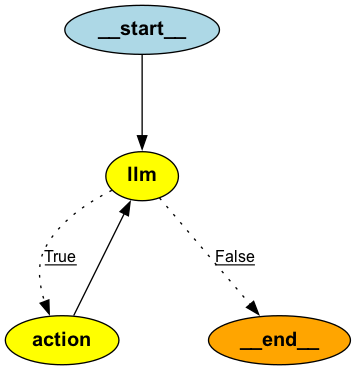

In [89]:
from IPython.display import Image

Image(i_am_an_agent.graph.get_graph().draw_png())

In [90]:
messages = [HumanMessage(content="What is the weather in utrecht this sunday?")]
messages = i_am_an_agent.graph.invoke({"messages": messages})
print(messages)
messages["messages"][-1].content

Calling: {'name': 'weather_report', 'args': {'latitude': 52.1, 'longitude': 5.1, 'timeframe': 45}, 'id': 'call_DGeVeJgK6JFosC8WDDVY4Zi5', 'type': 'tool_call'}
Back to the model!
{'messages': [HumanMessage(content='What is the weather in utrecht this sunday?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_DGeVeJgK6JFosC8WDDVY4Zi5', 'function': {'arguments': '{"latitude":52.1,"longitude":5.1,"timeframe":45}', 'name': 'weather_report'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 395, 'total_tokens': 422, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-abdb68e4-1b62-4a16-b482-825199305a94-0', tool_calls=[{'name': 'weather_report', 'ar

'The weather in Utrecht this Sunday is expected to be cloudy with a mix of clear and medium or low clouds. The temperature will range from 10°C to 15°C with a slight chance of rain (10%). The wind will be coming from the southwest direction with a speed of 2.06 m/s.'

In [91]:
# it is actually wrong, coordinates are from amsterdam, it's easier to search

In [93]:
messages = [
    HumanMessage(content="I want to learn good morals and the government of my temper")
]
messages = i_am_an_agent.graph.invoke({"messages": messages})
print(messages)
messages["messages"][-1].content

Calling: {'name': 'stoic_collection_search', 'args': {'query': 'good morals and government of temper'}, 'id': 'call_4SywQhNAHCXJQq1IFYF5h7d3', 'type': 'tool_call'}
Back to the model!
{'messages': [HumanMessage(content='I want to learn good morals and the government of my temper', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4SywQhNAHCXJQq1IFYF5h7d3', 'function': {'arguments': '{"query":"good morals and government of temper"}', 'name': 'stoic_collection_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 398, 'total_tokens': 420, 'completion_tokens_details': {'audio_tokens': None, 'reasoning_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-cefe0034-6a7e-4b6c-9be8-fbca338674f1-0', tool_calls=[

'Here is what Marcus Aurelius had to say on this matter:\n"From my grandfather Verus I learned good morals and the government of my temper."'

In [95]:
messages = [HumanMessage(content="How old is Naruto Uzumaki?")]
messages = i_am_an_agent.graph.invoke({"messages": messages})
print(messages)
messages["messages"][-1].content

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Age of Naruto Uzumaki'}, 'id': 'call_Z45XS9jLuzegRCzic4NX1LH3', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Naruto Uzumaki birthdate'}, 'id': 'call_9hOl9ruT61tVkNWzcZcnhnL8', 'type': 'tool_call'}
Back to the model!
{'messages': [HumanMessage(content='How old is Naruto Uzumaki?', additional_kwargs={}, response_metadata={}), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_Z45XS9jLuzegRCzic4NX1LH3', 'function': {'arguments': '{"query": "Age of Naruto Uzumaki"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'call_9hOl9ruT61tVkNWzcZcnhnL8', 'function': {'arguments': '{"query": "Naruto Uzumaki birthdate"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 65, 'prompt_tokens': 395, 'total_tokens': 460, 'completion_tokens_details': {'audio_tokens': None, 're

'Naruto Uzumaki starts his journey as a tween at 12 years old and by the end of the first arc, he is 17 years old. Most of the main action takes place two years after the Great Ninja War, making Naruto and his friends 19 years old.'

## What about other frameworks?

In [96]:
from llama_index.core.agent import ReActAgent
from llama_index.core.tools import FunctionTool
from llama_index.llms.together import TogetherLLM

/Users/dmitrykutsev/repos/learn_langgraph/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [136]:
def li_tavily_search(query, n_results=4) -> dict:
    """
    Conduct a search on the topic of [user's query topic] and provide a concise, accurate summary based on the most relevant results
    use minimum 3 results.
    """
    return tavily_client.search(query, max_results=n_results)

In [137]:
def li_weather_report(
    latitude: float = 52.1, longitude: float = 5.10, timeframe: int = 45
) -> dict:
    """
    Use this with every weather question. Use coordinates from the request if you find any
    """

    return buienradar_instance.fetch_weather_data(
        latitude=latitude, longitude=longitude, timeframe=timeframe
    )

In [138]:
def li_stoic_collection_search(query, n_results=4) -> dict:
    """
    Searches a stoic quote in a collection. Use when needed advice on an emotional or life-relational situation.
    The closest quote is the answer.cUse only the quote without changing.
    The response should begin with ‘Here is what Marcus Aurelius had to say on this matter.’”
    """

    return collection.query(
        query_texts=[query],
        n_results=n_results,
    )  # type: ignore

In [139]:
TOGETHER_API_KEY = os.getenv("TOGETHER_API_KEY")
CURR_LLM_MODEL = os.getenv("CURR_LLM_MODEL")

In [140]:
li_llm = TogetherLLM(
    model=CURR_LLM_MODEL,
    api_key=TOGETHER_API_KEY,
)

In [141]:
li_tavily_tool = FunctionTool.from_defaults(fn=li_tavily_search)
li_stoic_collection_tool = FunctionTool.from_defaults(fn=li_stoic_collection_search)
li_weather_tool = FunctionTool.from_defaults(fn=li_weather_report)

In [142]:
li_agent = ReActAgent.from_tools(
    [li_tavily_tool, li_stoic_collection_tool, li_weather_tool], llm=li_llm, verbose=True, max_iterations=20,
)

In [143]:
li_agent.chat("How old is Naruto Uzumaki?")

> Running step 041cc4ce-bb67-481f-a7fd-4d9daa0beedf. Step input: How old is Naruto Uzumaki?
Thought: The current language of the user is: English. I need to use a tool to help me answer the question.
Action: li_tavily_search
Action Input: {'query': 'Naruto Uzumaki age', 'n_results': 1}
Observation: {'query': 'Naruto Uzumaki age', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'title': "How old is Naruto? Naruto Uzumaki's age throughout his namesake ...", 'url': 'https://wegotthiscovered.com/anime/how-old-is-naruto-naruto-uzumakis-age-throughout-his-namesake-franchise-explained/', 'content': 'How Old Is Naruto? How old is Naruto? Naruto Uzumaki starts off his long journey as a tween, 12 years old to be exact. Airing from 2002 to 2007, the first part of the Naruto series showcases the protagonist as a pre-teen, from 12 to 13 years old. By the end of this arc, Naruto and Jiraya begin their return trip to the Leaf Village after nearly three years away. By the end, 

AgentChatResponse(response='Naruto Uzumaki is 12 years old at the beginning of his journey, 17 years old at the end of the first part of the series, and 19 years old in The Last: Naruto the Movie.', sources=[ToolOutput(content='{\'query\': \'Naruto Uzumaki age\', \'follow_up_questions\': None, \'answer\': None, \'images\': [], \'results\': [{\'title\': "How old is Naruto? Naruto Uzumaki\'s age throughout his namesake ...", \'url\': \'https://wegotthiscovered.com/anime/how-old-is-naruto-naruto-uzumakis-age-throughout-his-namesake-franchise-explained/\', \'content\': \'How Old Is Naruto? How old is Naruto? Naruto Uzumaki starts off his long journey as a tween, 12 years old to be exact. Airing from 2002 to 2007, the first part of the Naruto series showcases the protagonist as a pre-teen, from 12 to 13 years old. By the end of this arc, Naruto and Jiraya begin their return trip to the Leaf Village after nearly three years away. By the end, Naruto is 17 years old and has undergone an epic j

In [145]:
li_agent.chat("What is the weather tomorrow in Tilburg?")

> Running step 04e59d99-a584-4dc9-8f0c-fa74339b1e0a. Step input: What is the weather tomorrow in Tilburg?
Thought: I need to use a tool to help me answer the question.
Action: li_weather_report
Action Input: {'latitude': 51.6, 'longitude': 5.1, 'timeframe': 1}
Observation: Error: Timeframe must be >=5 and <=120.
> Running step dbd51c6f-df5d-4ac1-a884-aef2faef9ff0. Step input: None
Thought: I need to use a tool to help me answer the question.
Action: li_weather_report
Action Input: {'latitude': 51.6, 'longitude': 5.1, 'timeframe': 24}
Observation: {'success': True, 'msg': None, 'data': {'attribution': 'Data provided by buienradar.nl', 'forecast': [{'condition': {'condcode': 'b', 'condition': 'cloudy', 'detailed': 'partlycloudy', 'exact': 'Mix of clear and medium or low clouds', 'exact_nl': 'Mix van opklaringen en middelbare of lage bewolking', 'night': False, 'image': 'https://www.buienradar.nl/resources/images/icons/weather/30x30/b.png'}, 'temperature': 15.0, 'mintemp': 10.0, 'maxtemp'

AgentChatResponse(response='Tomorrow in Tilburg, it will be cloudy with a temperature of 16.0°C.', sources=[ToolOutput(content='Error: Timeframe must be >=5 and <=120.', tool_name='li_weather_report', raw_input={'kwargs': {'latitude': 51.6, 'longitude': 5.1, 'timeframe': 1}}, raw_output=ValueError('Timeframe must be >=5 and <=120.'), is_error=True), ToolOutput(content="{'success': True, 'msg': None, 'data': {'attribution': 'Data provided by buienradar.nl', 'forecast': [{'condition': {'condcode': 'b', 'condition': 'cloudy', 'detailed': 'partlycloudy', 'exact': 'Mix of clear and medium or low clouds', 'exact_nl': 'Mix van opklaringen en middelbare of lage bewolking', 'night': False, 'image': 'https://www.buienradar.nl/resources/images/icons/weather/30x30/b.png'}, 'temperature': 15.0, 'mintemp': 10.0, 'maxtemp': 15.0, 'sunchance': 30, 'rainchance': 10, 'rain': 0.0, 'minrain': 0.0, 'maxrain': 0.0, 'snow': 0, 'windforce': 2, 'windspeed': 2.06, 'winddirection': 'ZW', 'windazimuth': 225, 'dat